# Time series forecasting

RNN (Recurrent Neural Network)의 Long Short Term Memory ( LSTM ) 모델 사용

https://www.tensorflow.org/tutorials/structured_data/time_series


In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
날씨 데이터 세트

Max Planck Institute for Biogeochemistry에 의해 기록 된 [날씨 시계열 데이터 세트]를 사용

대기 온도, 대기압 및 습도와 같은 14 가지 특징으로 구성
2009 년과 2016 년 사이에 수집 된 데이터 만 사용

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

C:\Users\서지희\.keras\datasets\jena_climate_2009_2016.csv


In [3]:
#pandas dataframe으로 csv파일 read
df = pd.read_csv(csv_path)

In [4]:
# 상위 데이터 목록 확인
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


데이터의 처음 300,000 개 행은 학습 데이터 세트(2100일 분량)이고 나머지는 유효성 검사 데이터 세트로 구성

In [5]:
TRAIN_SPLIT = 300000

재현성을 보장하기 위해 시드 설정.

In [6]:
tf.random.set_seed(13)

In [7]:
def create_time_steps(length):
  return list(range(-length, 0))

In [8]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

#### Forecast a multivariate time series

3개의 특징(온도, 대기압 및 공기 밀도)로  일정기간 온도예측


### (1)3개의 특징만 추출

In [9]:

features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [10]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

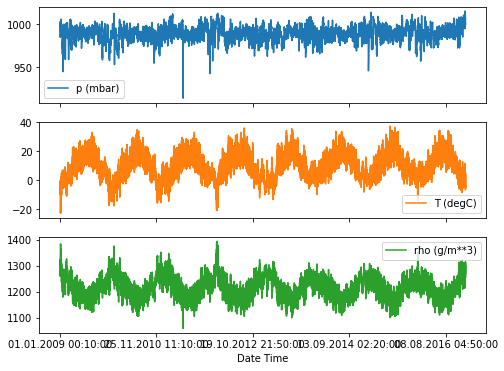

In [11]:
features.plot(subplots=True)

### (2) 표준화 

In [12]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [13]:
dataset = (dataset-data_mean)/data_std

## Multi-Step model

다단계 예측 모델은 과거 히스토리로 미래의 값 범위를 예측하는 방법으로 미래의 시퀀스를 예측

5일동안의 기록을 이용하여 12시간 동안의 온도를 예측 

In [14]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])  #Multi-Step, 시퀀스로 추출

  return np.array(data), np.array(labels)

### (3)데이터 윈도우 추출


5일동안의 기록을 이용하여 12시간의 온도를 예측

10분 단위로 관측된 값이므로 한시간에 6개, 하루에 144(6 * 24))개 관측값

window 추출  
- x : 지난 5일의 온도 관측값 720 (5 * 144)   
- step : 이동단위 1시간, 6  
- y : 12시간동안의 미래값 예측값 72 (12 * 6)    

In [15]:
past_history = 720  #지난 5일의 온도 관측값 720 (5 * 144)
future_target = 72  #12시간동안의 미래값 예측값 72 (12 * 6)  
STEP = 6            #1시간 단위로 이동 

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP, single_step=False)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, single_step=False)

In [16]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


### (4) LSTM 데이터 입력  구조로 학습데이터, 테스트 데이터 추출

In [17]:
#train, validation  data를 텐서로 변경하여 batch size만큼 추출

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [28]:
print('train_data_multi\n',train_data_multi)
print('\n\nval_data_multi\n',val_data_multi)

train_data_multi
 <RepeatDataset shapes: ((None, 120, 3), (None, 72)), types: (tf.float64, tf.float64)>


val_data_multi
 <RepeatDataset shapes: ((None, 120, 3), (None, 72)), types: (tf.float64, tf.float64)>


### (5) 다단계 예측 모델 Plotting

In [18]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

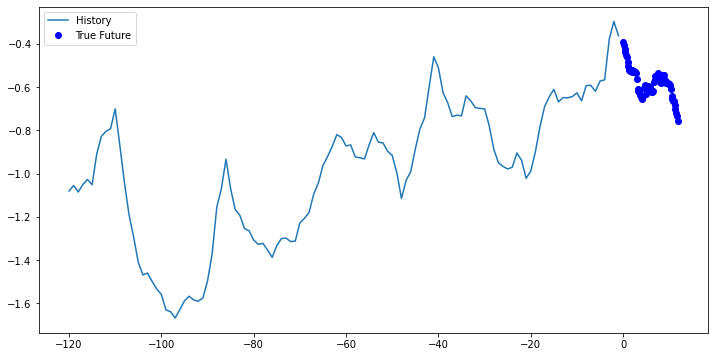

In [19]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

### (6)모델 구성

다단계 예측모델은 이전 작업보다 약간 복잡하기 때문에 두 개의 LSTM 계층으로 구성  
마지막 layer에서는 72 개의 예측을 출력

In [20]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))  #72개 시퀀스 예측

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [21]:
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


### (7)모델 학습

In [22]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 24s 111ms/step - loss: 0.6823 - val_loss: 0.3212

### (8) 학습결과 플로팅

In [23]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

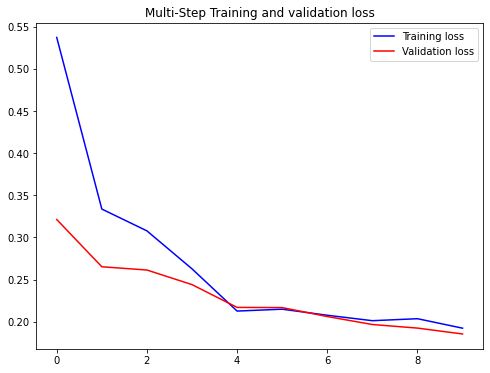

In [24]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

### (9) Predict a multi-step future
학습된 모델을 이용한 다단계 예측

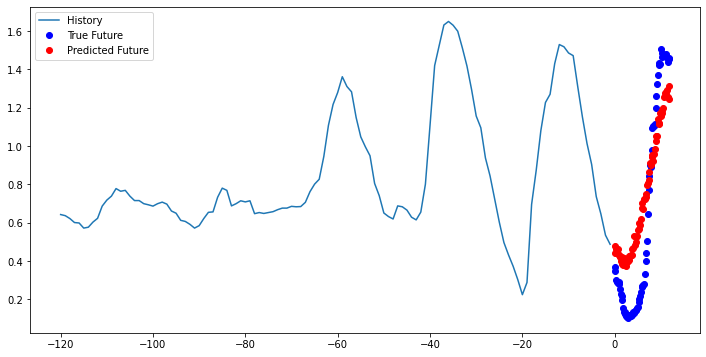

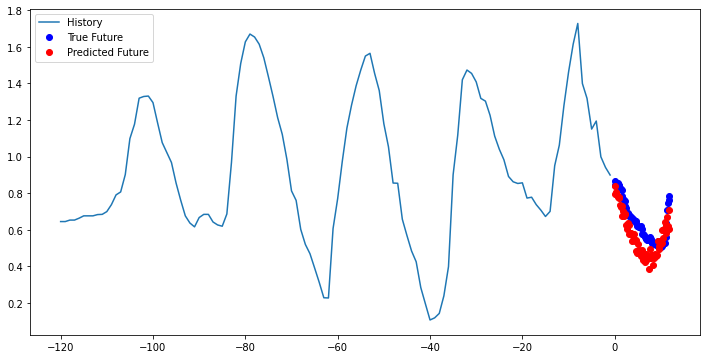

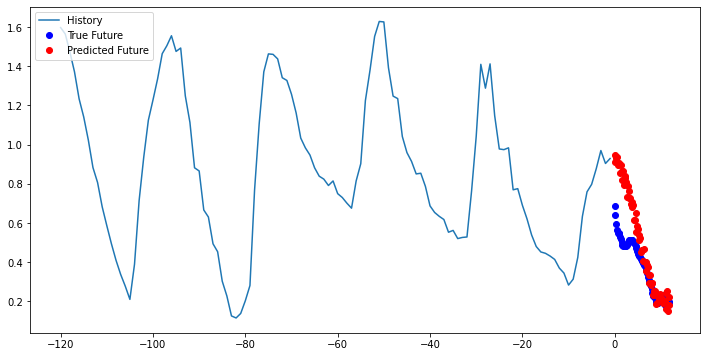

In [25]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

### (10)모델 평가하기

In [26]:
# 모델 평가하기
trainScore = multi_step_model.evaluate(x_train_multi, y_train_multi, verbose=0)
print('Train Score: ', trainScore)
valScore = multi_step_model.evaluate(x_val_multi, y_val_multi, verbose=0)
print('Validataion Score: ', valScore)

Train Score:  0.19773492217063904
Validataion Score:  0.19747592508792877
